In [7]:
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.core import Hamiltonian,QubitMappingType
from qiskit.aqua import QuantumInstance, aqua_globals


In [9]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' 
distances = np.arange(0.5,4.25,0.25)
vqe_energies = []
hf_energies = [] # initial guess from Hartree-Fock
exact_energies = []

In [10]:
for i,d in enumerate(distances):
  print('step',i)

  # set up experiment

  driver = PySCFDriver(molecule.format(d/2), basis = 'sto3g')
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                         two_qubit_reduction=True, 
                         freeze_core=True,
                         orbital_reduction=[-3,-2])
  qubit_op, aux_ops = operator.run(qmolecule)

  # exact classical result

  exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
  exact_result = operator.process_algorithm_result(exact_result)

  # VQE
  optimizer = SLSQP(maxiter=1000)
  initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                              operator.molecule_info['num_particles'],
                              qubit_mapping=operator._qubit_mapping,
                              two_qubit_reduction=operator._two_qubit_reduction)
  
  var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   initial_state=initial_state,
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction=operator._two_qubit_reduction)
  
  algo=VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)

  vqe_result=algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
  vqe_result=operator.process_algorithm_result(vqe_result)

  exact_energies.append(exact_result.energy)
  vqe_energies.append(vqe_result.energy)
  hf_energies.append(vqe_result.hartree_fock_energy)

step 0


QiskitChemistryError: 'PySCF is not installed. See https://sunqm.github.io/pyscf/install.html'

ValueError: x and y must have same first dimension, but have shapes (15,) and (0,)

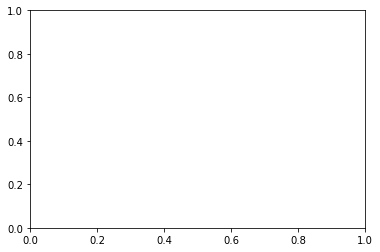

In [11]:
 pylab.plot(distances,hf_energies, label='Hartree_Fock')
 pylab.plot(distances, vqe_energies, 'o', label='VQE')
 pylab.plot(distances, exact_energies, '^', label='Exact')

 pylab.xlabel('Interatomic Distance')
 pylab.ylabel('Energy')
 pylab.title('LiH Ground State Energy')
 pylab.legend()